Best Parameters: {'rf__max_depth': 30, 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 10, 'rf__n_estimators': 200}
Best F1 Score (CV Avg): 0.8361

Classification Report on Test Set:
               precision    recall  f1-score   support

         0.0       0.88      0.78      0.83      3738
         1.0       0.87      0.91      0.89      9432
         2.0       0.83      0.84      0.83      4251

    accuracy                           0.86     17421
   macro avg       0.86      0.84      0.85     17421
weighted avg       0.86      0.86      0.86     17421



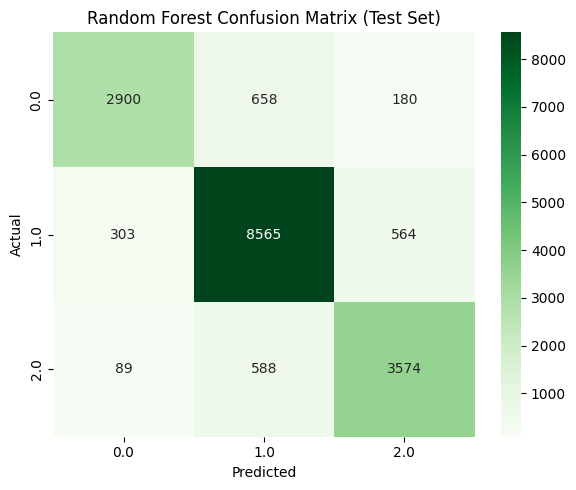

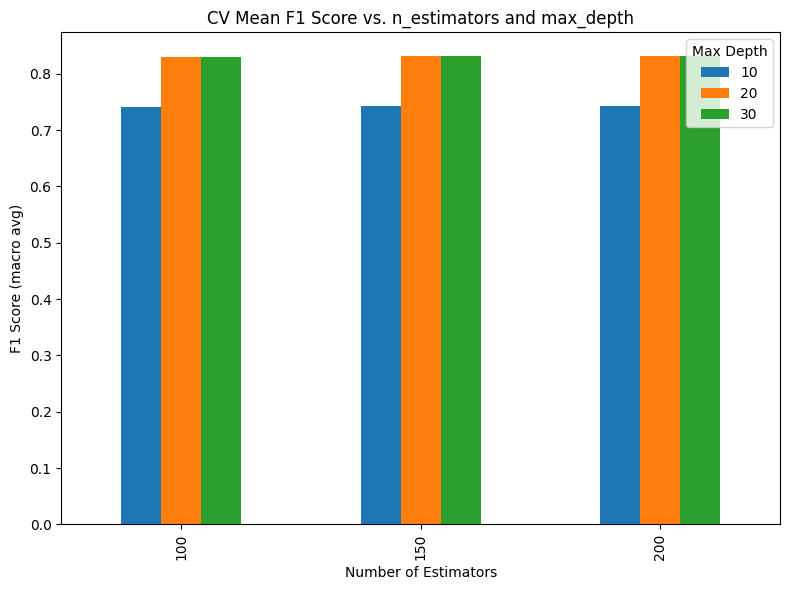

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix


df_sensor = pd.read_csv("datasets/assignTTSWING_sensor_only.csv")
X = df_sensor.drop(columns=['playYears'])
y = df_sensor['playYears']
classes = np.unique(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('rf', RandomForestClassifier(
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ))
])


param_grid = {
    'rf__n_estimators': [100, 150, 200],
    'rf__max_depth': [10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],        
    'rf__min_samples_leaf': [1, 2, 4]
}


cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1,
    return_train_score=True
)


grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print(f"Best F1 Score (CV Avg): {grid_search.best_score_:.4f}")

y_pred = grid_search.predict(X_test)
print("\nClassification Report on Test Set:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=classes, yticklabels=classes)
plt.title("Random Forest Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

results = pd.DataFrame(grid_search.cv_results_)
pivot_table = results.pivot_table(
    values='mean_test_score',
    index='param_rf__n_estimators',
    columns='param_rf__max_depth'
)

pivot_table.plot(kind='bar', figsize=(8, 6))
plt.title("CV Mean F1 Score vs. n_estimators and max_depth")
plt.ylabel("F1 Score (macro avg)")
plt.xlabel("Number of Estimators")
plt.legend(title="Max Depth")
plt.tight_layout()
plt.show()


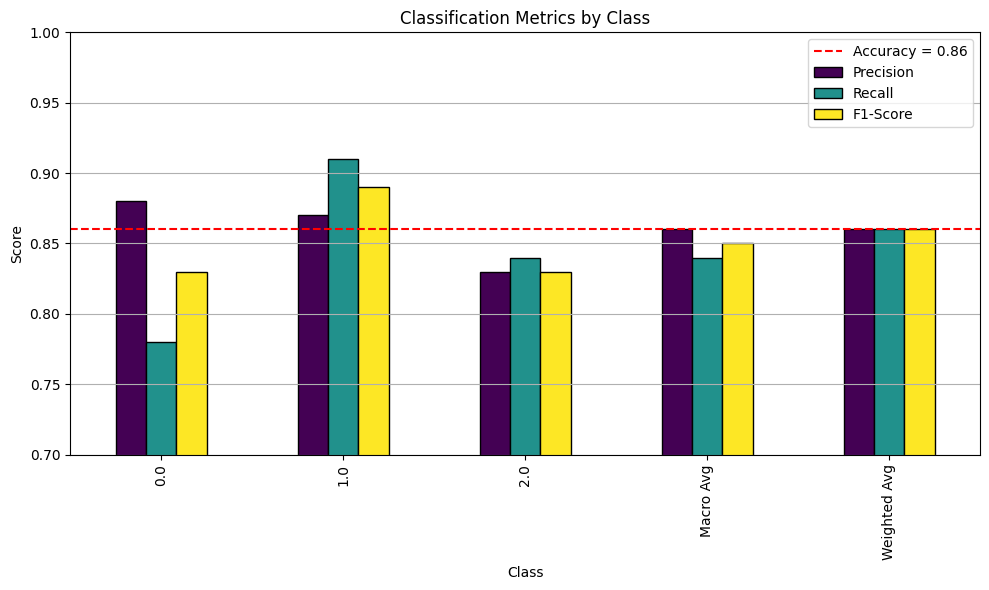

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

metrics = {
    'Class': ['0.0', '1.0', '2.0', 'Macro Avg', 'Weighted Avg'],
    'Precision': [0.88, 0.87, 0.83, 0.86, 0.86],
    'Recall':    [0.78, 0.91, 0.84, 0.84, 0.86],
    'F1-Score':  [0.83, 0.89, 0.83, 0.85, 0.86],
    'Support':   [3738, 9432, 4251, 17421, 17421]
}

df_metrics = pd.DataFrame(metrics)
df_metrics.set_index('Class', inplace=True)


accuracy = 0.86


ax = df_metrics[['Precision', 'Recall', 'F1-Score']].plot(
    kind='bar', figsize=(10, 6), colormap='viridis', edgecolor='black'
)
plt.axhline(y=accuracy, color='red', linestyle='--', linewidth=1.5, label=f'Accuracy = {accuracy:.2f}')
plt.title('Classification Metrics by Class')
plt.ylabel('Score')
plt.ylim(0.7, 1.0)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


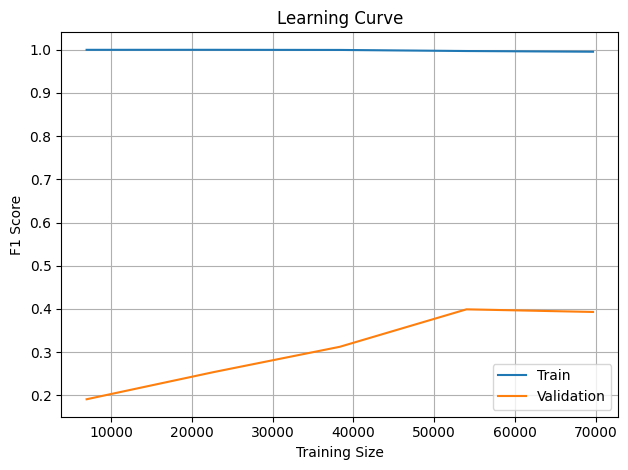

In [7]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    grid_search.best_estimator_, X, y, cv=5, scoring='f1_macro', train_sizes=np.linspace(0.1, 1.0, 5)
)

plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation')
plt.xlabel("Training Size")
plt.ylabel("F1 Score")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


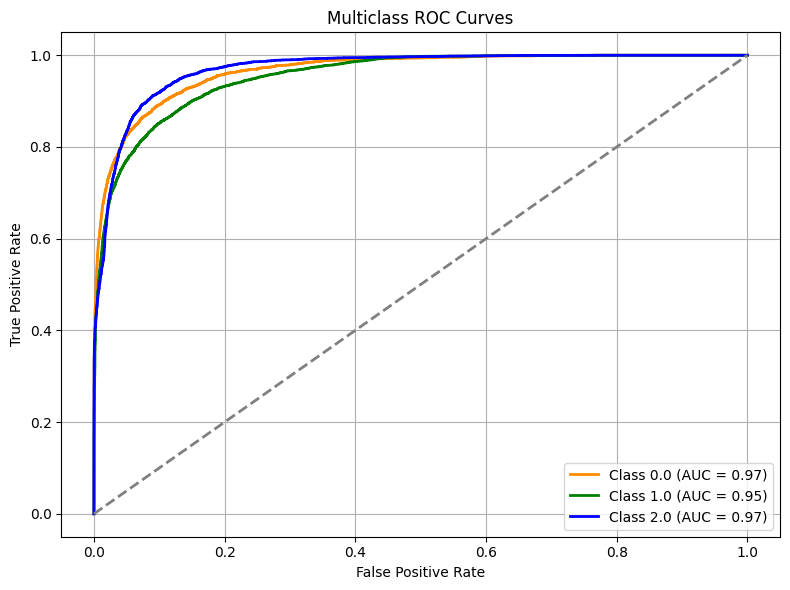

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

df_sensor = pd.read_csv("datasets/assignTTSWING_sensor_only.csv")
X = df_sensor.drop(columns=['playYears'])
y = df_sensor['playYears']
classes = np.unique(y)
n_classes = len(classes)

y_bin = label_binarize(y, classes=classes)


X_train, X_test, y_train, y_test = train_test_split(
    X, y_bin, test_size=0.2, stratify=y, random_state=42
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', OneVsRestClassifier(RandomForestClassifier(
        n_estimators=200,
        max_depth=30,
        min_samples_split=10,
        min_samples_leaf=4,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )))
])

pipeline.fit(X_train, y_train)

y_score = pipeline.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['darkorange', 'green', 'blue']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curves")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


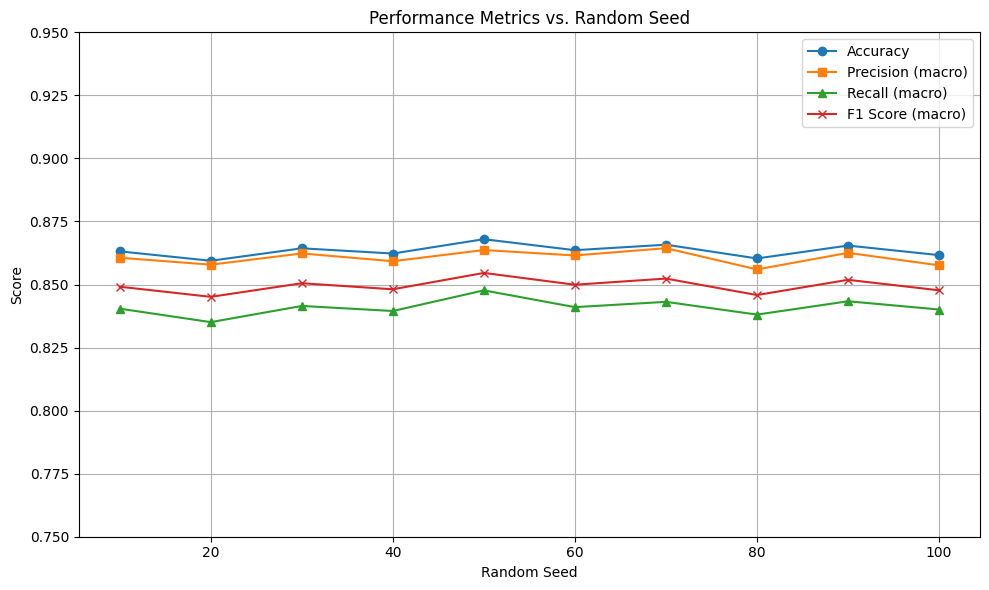

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

df_sensor = pd.read_csv("datasets/assignTTSWING_sensor_only.csv")
X = df_sensor.drop(columns=['playYears'])
y = df_sensor['playYears']
classes = np.unique(y)

results = {
    'seed': [],
    'accuracy': [],
    'precision_macro': [],
    'recall_macro': [],
    'f1_macro': []
}

seeds = list(range(10, 110, 10)) 

for seed in seeds:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=seed
    )


    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(
            n_estimators=200,
            max_depth=30,
            min_samples_split=10,
            min_samples_leaf=4,
            class_weight='balanced',
            random_state=seed,
            n_jobs=-1
        ))
    ])

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    results['seed'].append(seed)
    results['accuracy'].append(accuracy_score(y_test, y_pred))
    results['precision_macro'].append(precision_score(y_test, y_pred, average='macro'))
    results['recall_macro'].append(recall_score(y_test, y_pred, average='macro'))
    results['f1_macro'].append(f1_score(y_test, y_pred, average='macro'))

df_results = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(df_results['seed'], df_results['accuracy'], label='Accuracy', marker='o')
plt.plot(df_results['seed'], df_results['precision_macro'], label='Precision (macro)', marker='s')
plt.plot(df_results['seed'], df_results['recall_macro'], label='Recall (macro)', marker='^')
plt.plot(df_results['seed'], df_results['f1_macro'], label='F1 Score (macro)', marker='x')
plt.title("Performance Metrics vs. Random Seed")
plt.xlabel("Random Seed")
plt.ylabel("Score")
plt.ylim(0.75, 0.95)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


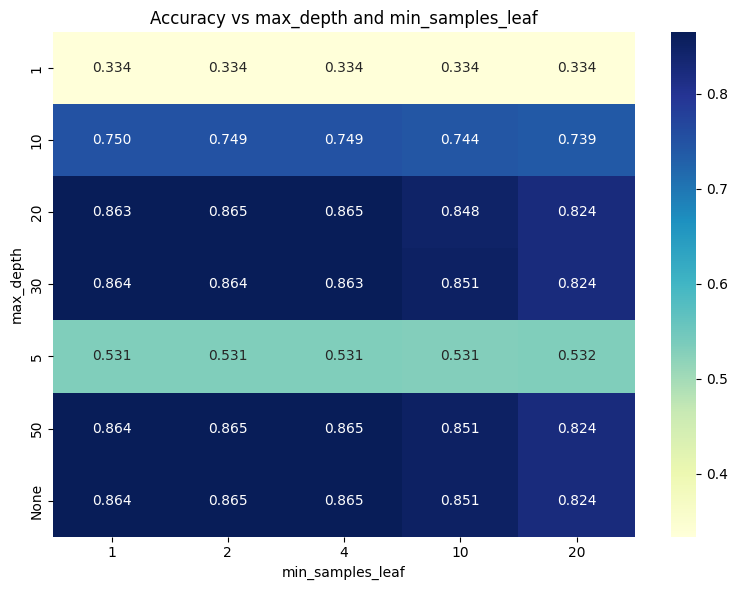

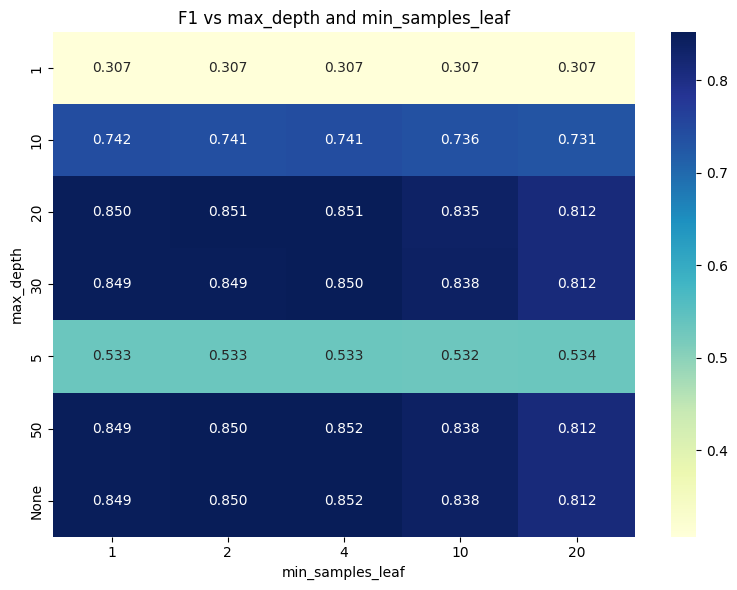

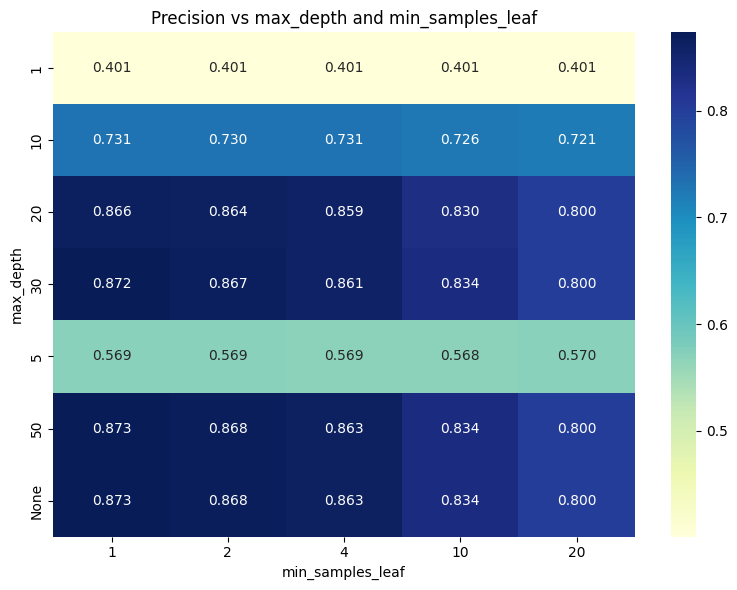

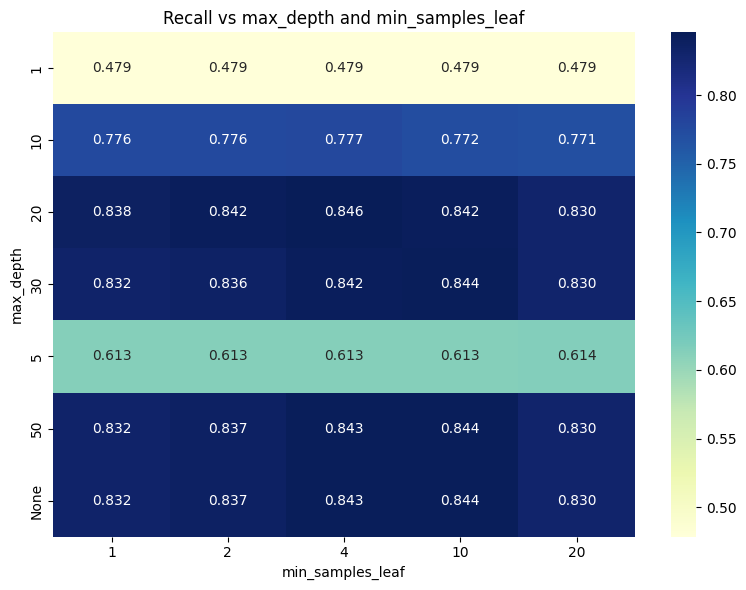

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df_sensor = pd.read_csv("datasets/assignTTSWING_sensor_only.csv")
X = df_sensor.drop(columns=['playYears'])
y = df_sensor['playYears']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

max_depth_range = [1, 5, 10, 20, 30, 50, None]  
min_samples_leaf_range = [1, 2, 4, 10, 20]

results = []

for max_depth in max_depth_range:
    for min_leaf in min_samples_leaf_range:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('rf', RandomForestClassifier(
                n_estimators=200,
                max_depth=max_depth,
                min_samples_split=10,
                min_samples_leaf=min_leaf,
                class_weight='balanced',
                random_state=42,
                n_jobs=-1
            ))
        ])

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)


        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        prec = precision_score(y_test, y_pred, average='macro')
        rec = recall_score(y_test, y_pred, average='macro')

        results.append({
            'max_depth': str(max_depth),
            'min_samples_leaf': min_leaf,
            'accuracy': acc,
            'f1': f1,
            'precision': prec,
            'recall': rec
        })


df_results = pd.DataFrame(results)


metrics = ['accuracy', 'f1', 'precision', 'recall']
for metric in metrics:
    pivot = df_results.pivot(index='max_depth', columns='min_samples_leaf', values=metric)
    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap="YlGnBu")
    plt.title(f"{metric.capitalize()} vs max_depth and min_samples_leaf")
    plt.xlabel("min_samples_leaf")
    plt.ylabel("max_depth")
    plt.tight_layout()
    plt.show()
